In [2]:
import os
import pickle
import shapely
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt

# Add main repo to path
import sys
from os.path import expanduser
sys.path.append(expanduser('../../'))

from spicy_snow.retrieval import retrieval_from_parameters, retrieve_snow_depth
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images
from spicy_snow.IO.user_dates import get_input_dates
from spicy_snow.download.sentinel1 import s1_img_search

In [3]:
quad_dir = Path('~/scratch/spicy-lowman-quadrant').expanduser()
quad_dir.exists()

lons = ['-115--114','-116--115', '-117--116']
lats = ['43-44', '44-45', '45-46']
lats = sorted(np.unique(lats))

XX, YY = np.meshgrid(lons, lats)
DAs = np.empty_like(XX).tolist()

for fp in quad_dir.glob('*.nc'):
    if '.un.nc' not in fp.name:
        ds = xr.open_dataset(fp)
        ds = ds['snow_depth']
        ds = ds.sel(time = slice('2020-11-01', '2021-03-01'))
        ds = ds.reindex(lat=list(reversed(ds.y)))
        ds = ds.reindex(lat=list(reversed(ds.x)))
        lon = fp.stem.split('_')[-2]
        lat = fp.stem.split('_')[-1]
        if lat in lats and lon in lons:
            idx, idy = np.array(list(np.where((XX == lon) & (YY == lat)))).ravel()
            DAs[idx][idy] = ds

In [4]:
res = xr.combine_nested(DAs, concat_dim= ['y','x'])
res = res.sortby('y')
res = res.sortby('x')

In [ ]:
res = merge_partial_s1_images(res.to_dataset(name = 'snow_depth'))['snow_depth']

In [ ]:
res.to_netcdf(quad_dir.joinpath('combo_v2.nc'))

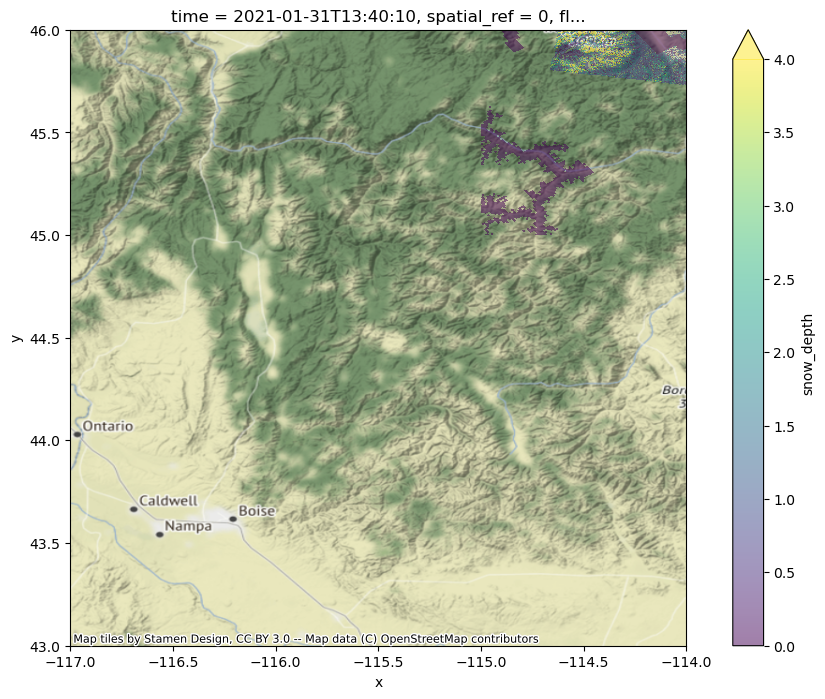

: 

In [4]:
import contextily as ctx
fig, ax = plt.subplots(figsize = (12, 8))
res.isel(time = 58).plot(vmax = 4, ax = ax, alpha = 0.5)
ctx.add_basemap(ax = ax, crs = 'EPSG:4326')